# DCGAN (Deep Convolutional GAN) : Convolution layer + GAN

- G와 D의 내부 구조를 Convolution layer로 구성 -> image 생성 성능 높아짐

In [1]:
import torch

from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.nn import Module, Sequential, ReLU, Tanh, LeakyReLU, Sigmoid, BCELoss, ConvTranspose2d, BatchNorm2d, Conv2d, init, Dropout
from torch.optim import Adam
from torchvision.utils import make_grid

import os
from time import time
from math import floor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = DataLoader(CIFAR10(root="data_cifar10", train=True, download=True, transform=transform),
                      batch_size=256,
                      shuffle=True,
                      num_workers=os.cpu_count()//2,
                      pin_memory=True,
                      persistent_workers=True
)

In [3]:
# image 생성
class Generator(Module):
    # latent_size : latent vector z의 크기
    def __init__(self, latent_size):
        super().__init__()
        
        self.model = Sequential(
            # ConvTranspose2d : 전치 합성곱 (image를 upsampling)
            # in_channel=latent_size, out_channel=256, kernel_size=4, stride=1, padding=0, bias=False
            # 1 * 1 * latent_size (input) -> 4 * 4 * 1024 (output)  
            # bias False : batch normalize 가 bias 역할을 대신함 (정규화 과정에서 bias 효과가 상쇄)
            ConvTranspose2d(latent_size, 1024, 4, 1, 0, bias=False),
            BatchNorm2d(1024),
            # inplace=True : 원본 덮어쓰기 (새로운 tensor가 생성되지 않음 - memory 절약, 연산 효율화)
            ReLU(True),

            # 이전 layer에서 넘어온 input에 stride 2, padding 1 을 통해 output이 두 배의 image로 변환
            # 4 * 4 * 1024 -> 8 * 8 * 512
            ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            BatchNorm2d(512),
            ReLU(True),

            # 8 * 8 * 512 -> 16 * 16 * 256
            ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            BatchNorm2d(256),
            ReLU(True),

            # 16* 16 * 256 -> 32 * 32 * 128
            ConvTranspose2d(256, 128, 4, 2, 1, bias=False), 
            BatchNorm2d(128),
            ReLU(True),
            
            # 32 * 32 * 128 -> 32 * 32 * 3
            # kernel size를 3으로, stride를 1로 해서 image size 변화 X
            # output : 32 * 32의 3개 channel (색상) image
            ConvTranspose2d(128, 3, 3, 1, 1, bias=False), 
            Tanh()
        )

    # z : latent vector = image
    def forward(self, z):
        # self.model[0].in_channels : 0번지 ConvTranspose2d 의 latent_size
        return self.model(z.view(-1, self.model[0].in_channels, 1, 1))

In [4]:
class Discriminator(Module):
    def __init__(self):
        super().__init__()

        self.model = Sequential(
            # 32 * 32 * 3 -> 16 * 16 * 64
            Conv2d(3, 64, 4, 2, 1, bias=False),
            LeakyReLU(0.2, inplace=True),
            Dropout(0.1),
            
            # 16 * 16 * 64 -> 8 * 8 * 128
            Conv2d(64, 128, 4, 2, 1, bias=False),
            BatchNorm2d(128),
            LeakyReLU(0.2, inplace=True),
            Dropout(0.1),
            
            # 8 * 8 * 128 -> 4 * 4 * 256
            Conv2d(128, 256, 4, 2, 1, bias=False),
            BatchNorm2d(256),
            LeakyReLU(0.2, inplace=True),
            Dropout(0.1),
            
            # 4 * 4 * 256 -> 1 * 1 * 1
            Conv2d(256, 1, 4, 1, 0, bias=False),
            Sigmoid()
        )
    
    # x : real image
    def forward(self, x):
        # flatten (0 또는 1)
        return self.model(x).view(-1, 1)


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")

elif torch.xpu.is_available():
    device = torch.device("xpu")

elif torch.backends.mps.is_available():
    device = torch.device("mps")

else: 
    device = torch.device("cpu")

device

device(type='cuda')

In [6]:
latent_size = 100

G = Generator(latent_size).to(device)
D = Discriminator().to(device)

In [ ]:
# 가중치 초기화
# 모든 convolution 계층을 평균 0, 표준편차 0.02인 정규분포로 초기화 -> 학습의 안정화를 위해
def weights_init(model):
    if isinstance(model, (ConvTranspose2d, Conv2d, BatchNorm2d)):
        init.normal_(model.weight.data, 0.0, 0.02)

print(G.apply(weights_init))
print(D.apply(weights_init))

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()

In [8]:
loss_function = BCELoss()

learning_rate = 0.0005

# betas = (beta1, beta2) -> 1차 모멘텀 계수-기울기 평균 (momentum), 2차 모멘텀 계수-기울기 제곱 평균 (RMSProp)
# default : (0.9,0.999) -> GAN 에서는 학습 불안정성을 줄이기 위해 0.5로 낮춤 = 기울기에 민감하게 변함 = 기울기 진동을 완화 = 학습 불안정성 완화
betas = (0.5, 0.999)

g_optimizer = Adam(G.parameters(), lr=learning_rate, betas=betas)
d_optimizer = Adam(D.parameters(), lr=learning_rate, betas=betas)

epoch:   1/300 	 D Loss: 0.493 G Loss: 1.638 	 32s
epoch:   2/300 	 D Loss: 0.533 G Loss: 1.606 	 9s
epoch:   3/300 	 D Loss: 0.565 G Loss: 1.432 	 9s
epoch:   4/300 	 D Loss: 0.574 G Loss: 1.303 	 9s
epoch:   5/300 	 D Loss: 0.577 G Loss: 1.279 	 9s
epoch:   6/300 	 D Loss: 0.587 G Loss: 1.196 	 9s
epoch:   7/300 	 D Loss: 0.590 G Loss: 1.179 	 9s
epoch:   8/300 	 D Loss: 0.610 G Loss: 1.084 	 9s
epoch:   9/300 	 D Loss: 0.621 G Loss: 1.014 	 9s
epoch:  10/300 	 D Loss: 0.619 G Loss: 1.036 	 9s


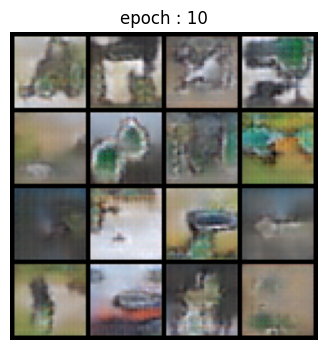

epoch:  11/300 	 D Loss: 0.616 G Loss: 1.023 	 9s
epoch:  12/300 	 D Loss: 0.616 G Loss: 1.016 	 9s
epoch:  13/300 	 D Loss: 0.621 G Loss: 1.004 	 9s
epoch:  14/300 	 D Loss: 0.625 G Loss: 0.988 	 9s
epoch:  15/300 	 D Loss: 0.627 G Loss: 0.979 	 9s
epoch:  16/300 	 D Loss: 0.626 G Loss: 0.977 	 9s
epoch:  17/300 	 D Loss: 0.628 G Loss: 0.968 	 9s
epoch:  18/300 	 D Loss: 0.629 G Loss: 0.962 	 9s
epoch:  19/300 	 D Loss: 0.632 G Loss: 0.960 	 9s
epoch:  20/300 	 D Loss: 0.631 G Loss: 0.953 	 9s


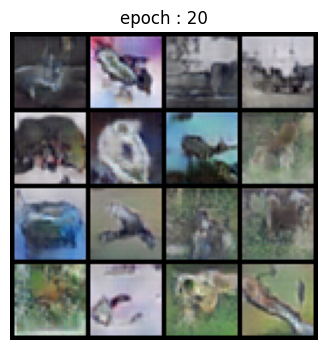

epoch:  21/300 	 D Loss: 0.629 G Loss: 0.952 	 9s
epoch:  22/300 	 D Loss: 0.630 G Loss: 0.954 	 9s
epoch:  23/300 	 D Loss: 0.630 G Loss: 0.952 	 9s
epoch:  24/300 	 D Loss: 0.628 G Loss: 0.940 	 9s
epoch:  25/300 	 D Loss: 0.631 G Loss: 0.951 	 9s
epoch:  26/300 	 D Loss: 0.628 G Loss: 0.949 	 9s
epoch:  27/300 	 D Loss: 0.629 G Loss: 0.953 	 9s
epoch:  28/300 	 D Loss: 0.628 G Loss: 0.962 	 9s
epoch:  29/300 	 D Loss: 0.626 G Loss: 0.948 	 9s
epoch:  30/300 	 D Loss: 0.629 G Loss: 0.947 	 9s


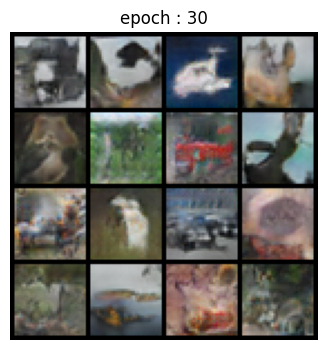

epoch:  31/300 	 D Loss: 0.632 G Loss: 0.957 	 9s
epoch:  32/300 	 D Loss: 0.624 G Loss: 0.954 	 9s
epoch:  33/300 	 D Loss: 0.625 G Loss: 0.955 	 9s
epoch:  34/300 	 D Loss: 0.625 G Loss: 0.962 	 9s
epoch:  35/300 	 D Loss: 0.626 G Loss: 0.959 	 9s
epoch:  36/300 	 D Loss: 0.624 G Loss: 0.962 	 9s
epoch:  37/300 	 D Loss: 0.625 G Loss: 0.969 	 9s
epoch:  38/300 	 D Loss: 0.623 G Loss: 0.966 	 9s
epoch:  39/300 	 D Loss: 0.624 G Loss: 0.963 	 9s
epoch:  40/300 	 D Loss: 0.620 G Loss: 0.966 	 9s


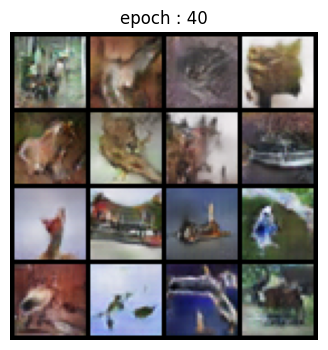

epoch:  41/300 	 D Loss: 0.621 G Loss: 0.975 	 9s
epoch:  42/300 	 D Loss: 0.620 G Loss: 0.982 	 9s
epoch:  43/300 	 D Loss: 0.620 G Loss: 0.975 	 9s
epoch:  44/300 	 D Loss: 0.621 G Loss: 0.976 	 9s
epoch:  45/300 	 D Loss: 0.616 G Loss: 0.979 	 9s
epoch:  46/300 	 D Loss: 0.616 G Loss: 0.973 	 9s
epoch:  47/300 	 D Loss: 0.620 G Loss: 0.985 	 9s
epoch:  48/300 	 D Loss: 0.620 G Loss: 0.989 	 9s
epoch:  49/300 	 D Loss: 0.612 G Loss: 0.982 	 9s
epoch:  50/300 	 D Loss: 0.616 G Loss: 0.992 	 9s


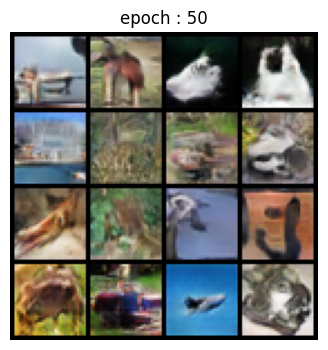

epoch:  51/300 	 D Loss: 0.613 G Loss: 0.993 	 9s
epoch:  52/300 	 D Loss: 0.619 G Loss: 1.006 	 10s
epoch:  53/300 	 D Loss: 0.613 G Loss: 0.984 	 9s
epoch:  54/300 	 D Loss: 0.609 G Loss: 1.007 	 9s
epoch:  55/300 	 D Loss: 0.617 G Loss: 1.001 	 9s
epoch:  56/300 	 D Loss: 0.608 G Loss: 1.008 	 9s
epoch:  57/300 	 D Loss: 0.608 G Loss: 1.009 	 9s
epoch:  58/300 	 D Loss: 0.610 G Loss: 1.018 	 9s
epoch:  59/300 	 D Loss: 0.607 G Loss: 1.016 	 9s
epoch:  60/300 	 D Loss: 0.606 G Loss: 1.016 	 9s


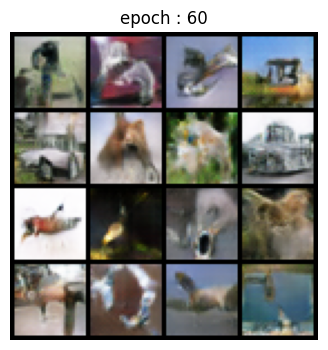

epoch:  61/300 	 D Loss: 0.608 G Loss: 1.025 	 9s
epoch:  62/300 	 D Loss: 0.606 G Loss: 1.026 	 9s
epoch:  63/300 	 D Loss: 0.603 G Loss: 1.033 	 9s
epoch:  64/300 	 D Loss: 0.602 G Loss: 1.030 	 9s
epoch:  65/300 	 D Loss: 0.602 G Loss: 1.034 	 9s
epoch:  66/300 	 D Loss: 0.602 G Loss: 1.035 	 9s
epoch:  67/300 	 D Loss: 0.601 G Loss: 1.046 	 9s
epoch:  68/300 	 D Loss: 0.598 G Loss: 1.042 	 9s
epoch:  69/300 	 D Loss: 0.601 G Loss: 1.055 	 9s
epoch:  70/300 	 D Loss: 0.600 G Loss: 1.051 	 9s


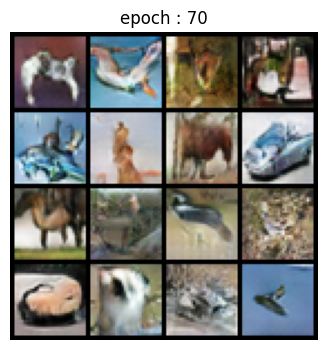

epoch:  71/300 	 D Loss: 0.599 G Loss: 1.051 	 9s
epoch:  72/300 	 D Loss: 0.598 G Loss: 1.054 	 9s
epoch:  73/300 	 D Loss: 0.595 G Loss: 1.056 	 9s
epoch:  74/300 	 D Loss: 0.598 G Loss: 1.067 	 9s
epoch:  75/300 	 D Loss: 0.593 G Loss: 1.068 	 9s
epoch:  76/300 	 D Loss: 0.598 G Loss: 1.070 	 9s
epoch:  77/300 	 D Loss: 0.592 G Loss: 1.066 	 9s
epoch:  78/300 	 D Loss: 0.592 G Loss: 1.064 	 9s
epoch:  79/300 	 D Loss: 0.596 G Loss: 1.085 	 9s
epoch:  80/300 	 D Loss: 0.598 G Loss: 1.076 	 9s


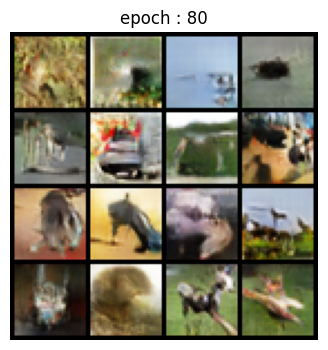

epoch:  81/300 	 D Loss: 0.587 G Loss: 1.061 	 9s
epoch:  82/300 	 D Loss: 0.592 G Loss: 1.084 	 9s
epoch:  83/300 	 D Loss: 0.588 G Loss: 1.086 	 9s
epoch:  84/300 	 D Loss: 0.588 G Loss: 1.084 	 9s
epoch:  85/300 	 D Loss: 0.589 G Loss: 1.089 	 9s
epoch:  86/300 	 D Loss: 0.591 G Loss: 1.086 	 9s
epoch:  87/300 	 D Loss: 0.588 G Loss: 1.088 	 9s
epoch:  88/300 	 D Loss: 0.595 G Loss: 1.087 	 9s
epoch:  89/300 	 D Loss: 0.584 G Loss: 1.087 	 9s
epoch:  90/300 	 D Loss: 0.589 G Loss: 1.097 	 9s


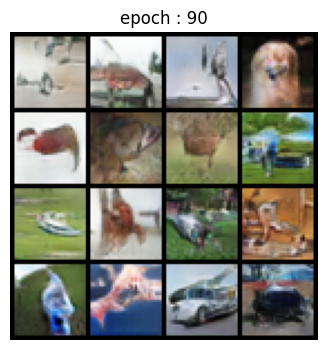

epoch:  91/300 	 D Loss: 0.586 G Loss: 1.090 	 9s
epoch:  92/300 	 D Loss: 0.586 G Loss: 1.111 	 9s
epoch:  93/300 	 D Loss: 0.586 G Loss: 1.097 	 9s
epoch:  94/300 	 D Loss: 0.587 G Loss: 1.110 	 9s
epoch:  95/300 	 D Loss: 0.584 G Loss: 1.107 	 9s
epoch:  96/300 	 D Loss: 0.583 G Loss: 1.115 	 9s
epoch:  97/300 	 D Loss: 0.585 G Loss: 1.113 	 9s
epoch:  98/300 	 D Loss: 0.582 G Loss: 1.113 	 9s
epoch:  99/300 	 D Loss: 0.583 G Loss: 1.115 	 9s
epoch: 100/300 	 D Loss: 0.580 G Loss: 1.124 	 9s


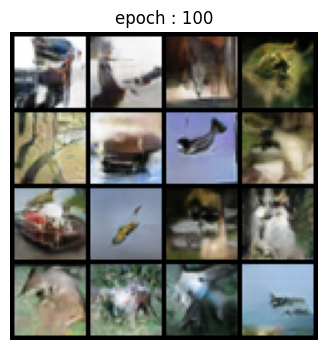

epoch: 101/300 	 D Loss: 0.583 G Loss: 1.128 	 9s
epoch: 102/300 	 D Loss: 0.586 G Loss: 1.135 	 9s
epoch: 103/300 	 D Loss: 0.576 G Loss: 1.113 	 9s
epoch: 104/300 	 D Loss: 0.593 G Loss: 1.134 	 9s
epoch: 105/300 	 D Loss: 0.577 G Loss: 1.120 	 9s
epoch: 106/300 	 D Loss: 0.580 G Loss: 1.118 	 9s
epoch: 107/300 	 D Loss: 0.578 G Loss: 1.132 	 9s
epoch: 108/300 	 D Loss: 0.577 G Loss: 1.130 	 9s
epoch: 109/300 	 D Loss: 0.587 G Loss: 1.138 	 9s
epoch: 110/300 	 D Loss: 0.574 G Loss: 1.132 	 9s


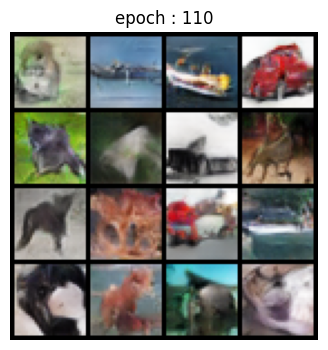

epoch: 111/300 	 D Loss: 0.579 G Loss: 1.135 	 9s
epoch: 112/300 	 D Loss: 0.577 G Loss: 1.144 	 9s
epoch: 113/300 	 D Loss: 0.577 G Loss: 1.141 	 9s
epoch: 114/300 	 D Loss: 0.578 G Loss: 1.140 	 9s
epoch: 115/300 	 D Loss: 0.586 G Loss: 1.144 	 9s
epoch: 116/300 	 D Loss: 0.571 G Loss: 1.138 	 9s
epoch: 117/300 	 D Loss: 0.573 G Loss: 1.151 	 9s
epoch: 118/300 	 D Loss: 0.579 G Loss: 1.151 	 9s
epoch: 119/300 	 D Loss: 0.570 G Loss: 1.159 	 9s
epoch: 120/300 	 D Loss: 0.575 G Loss: 1.162 	 9s


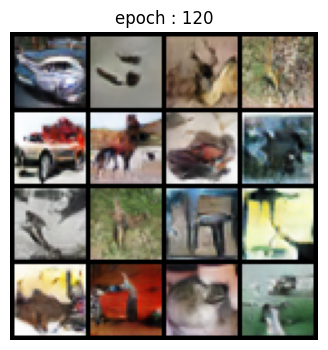

epoch: 121/300 	 D Loss: 0.577 G Loss: 1.164 	 9s
epoch: 122/300 	 D Loss: 0.572 G Loss: 1.162 	 9s
epoch: 123/300 	 D Loss: 0.575 G Loss: 1.161 	 9s
epoch: 124/300 	 D Loss: 0.572 G Loss: 1.157 	 9s
epoch: 125/300 	 D Loss: 0.573 G Loss: 1.164 	 9s
epoch: 126/300 	 D Loss: 0.570 G Loss: 1.158 	 9s
epoch: 127/300 	 D Loss: 0.589 G Loss: 1.178 	 9s
epoch: 128/300 	 D Loss: 0.566 G Loss: 1.147 	 9s
epoch: 129/300 	 D Loss: 0.572 G Loss: 1.171 	 9s
epoch: 130/300 	 D Loss: 0.567 G Loss: 1.168 	 9s


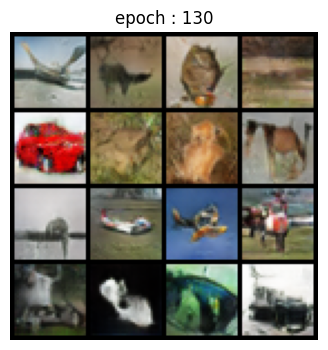

epoch: 131/300 	 D Loss: 0.572 G Loss: 1.175 	 9s
epoch: 132/300 	 D Loss: 0.577 G Loss: 1.173 	 9s
epoch: 133/300 	 D Loss: 0.569 G Loss: 1.175 	 9s
epoch: 134/300 	 D Loss: 0.569 G Loss: 1.177 	 9s
epoch: 135/300 	 D Loss: 0.576 G Loss: 1.168 	 9s
epoch: 136/300 	 D Loss: 0.569 G Loss: 1.170 	 9s
epoch: 137/300 	 D Loss: 0.568 G Loss: 1.192 	 9s
epoch: 138/300 	 D Loss: 0.569 G Loss: 1.183 	 9s
epoch: 139/300 	 D Loss: 0.572 G Loss: 1.174 	 9s
epoch: 140/300 	 D Loss: 0.567 G Loss: 1.176 	 9s


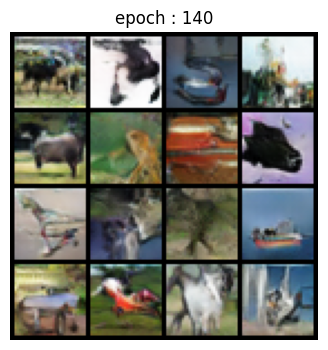

epoch: 141/300 	 D Loss: 0.567 G Loss: 1.191 	 9s
epoch: 142/300 	 D Loss: 0.568 G Loss: 1.202 	 9s
epoch: 143/300 	 D Loss: 0.565 G Loss: 1.195 	 9s
epoch: 144/300 	 D Loss: 0.565 G Loss: 1.199 	 9s
epoch: 145/300 	 D Loss: 0.566 G Loss: 1.196 	 9s
epoch: 146/300 	 D Loss: 0.569 G Loss: 1.193 	 9s
epoch: 147/300 	 D Loss: 0.564 G Loss: 1.201 	 9s
epoch: 148/300 	 D Loss: 0.574 G Loss: 1.210 	 9s
epoch: 149/300 	 D Loss: 0.560 G Loss: 1.188 	 9s
epoch: 150/300 	 D Loss: 0.565 G Loss: 1.195 	 9s


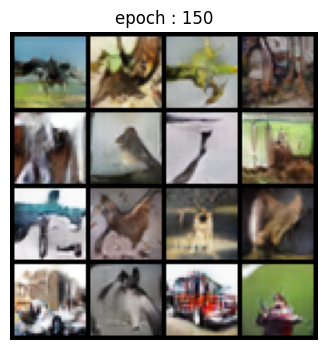

epoch: 151/300 	 D Loss: 0.563 G Loss: 1.200 	 9s
epoch: 152/300 	 D Loss: 0.568 G Loss: 1.208 	 9s
epoch: 153/300 	 D Loss: 0.563 G Loss: 1.208 	 9s
epoch: 154/300 	 D Loss: 0.566 G Loss: 1.204 	 9s
epoch: 155/300 	 D Loss: 0.564 G Loss: 1.207 	 9s
epoch: 156/300 	 D Loss: 0.562 G Loss: 1.206 	 9s
epoch: 157/300 	 D Loss: 0.566 G Loss: 1.212 	 9s
epoch: 158/300 	 D Loss: 0.562 G Loss: 1.215 	 9s
epoch: 159/300 	 D Loss: 0.568 G Loss: 1.211 	 9s
epoch: 160/300 	 D Loss: 0.560 G Loss: 1.203 	 9s


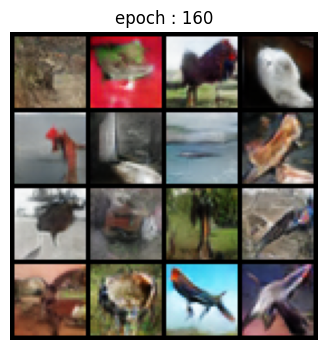

epoch: 161/300 	 D Loss: 0.561 G Loss: 1.214 	 9s
epoch: 162/300 	 D Loss: 0.573 G Loss: 1.226 	 9s
epoch: 163/300 	 D Loss: 0.558 G Loss: 1.188 	 9s
epoch: 164/300 	 D Loss: 0.560 G Loss: 1.216 	 9s
epoch: 165/300 	 D Loss: 0.564 G Loss: 1.222 	 9s
epoch: 166/300 	 D Loss: 0.560 G Loss: 1.222 	 9s
epoch: 167/300 	 D Loss: 0.561 G Loss: 1.225 	 9s
epoch: 168/300 	 D Loss: 0.559 G Loss: 1.221 	 9s
epoch: 169/300 	 D Loss: 0.564 G Loss: 1.224 	 9s
epoch: 170/300 	 D Loss: 0.559 G Loss: 1.227 	 9s


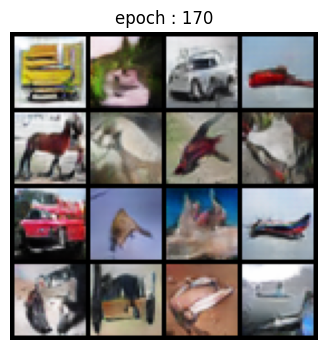

epoch: 171/300 	 D Loss: 0.564 G Loss: 1.226 	 9s
epoch: 172/300 	 D Loss: 0.562 G Loss: 1.229 	 9s
epoch: 173/300 	 D Loss: 0.558 G Loss: 1.230 	 9s
epoch: 174/300 	 D Loss: 0.564 G Loss: 1.227 	 9s
epoch: 175/300 	 D Loss: 0.559 G Loss: 1.221 	 9s
epoch: 176/300 	 D Loss: 0.556 G Loss: 1.226 	 9s
epoch: 177/300 	 D Loss: 0.568 G Loss: 1.233 	 9s
epoch: 178/300 	 D Loss: 0.553 G Loss: 1.229 	 9s
epoch: 179/300 	 D Loss: 0.559 G Loss: 1.234 	 9s
epoch: 180/300 	 D Loss: 0.554 G Loss: 1.236 	 9s


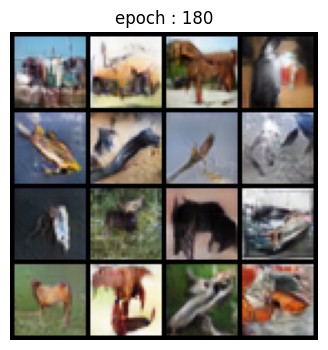

epoch: 181/300 	 D Loss: 0.557 G Loss: 1.249 	 9s
epoch: 182/300 	 D Loss: 0.560 G Loss: 1.253 	 9s
epoch: 183/300 	 D Loss: 0.556 G Loss: 1.237 	 9s
epoch: 184/300 	 D Loss: 0.558 G Loss: 1.241 	 9s
epoch: 185/300 	 D Loss: 0.557 G Loss: 1.239 	 9s
epoch: 186/300 	 D Loss: 0.555 G Loss: 1.247 	 9s
epoch: 187/300 	 D Loss: 0.559 G Loss: 1.239 	 9s
epoch: 188/300 	 D Loss: 0.557 G Loss: 1.250 	 9s
epoch: 189/300 	 D Loss: 0.556 G Loss: 1.249 	 9s
epoch: 190/300 	 D Loss: 0.554 G Loss: 1.256 	 9s


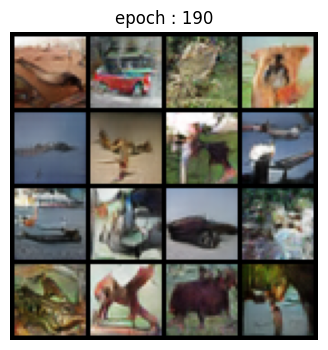

epoch: 191/300 	 D Loss: 0.555 G Loss: 1.247 	 9s
epoch: 192/300 	 D Loss: 0.558 G Loss: 1.252 	 9s
epoch: 193/300 	 D Loss: 0.554 G Loss: 1.250 	 9s
epoch: 194/300 	 D Loss: 0.556 G Loss: 1.252 	 9s
epoch: 195/300 	 D Loss: 0.556 G Loss: 1.251 	 9s
epoch: 196/300 	 D Loss: 0.554 G Loss: 1.243 	 9s
epoch: 197/300 	 D Loss: 0.553 G Loss: 1.250 	 9s
epoch: 198/300 	 D Loss: 0.555 G Loss: 1.250 	 9s
epoch: 199/300 	 D Loss: 0.555 G Loss: 1.257 	 9s
epoch: 200/300 	 D Loss: 0.555 G Loss: 1.255 	 9s


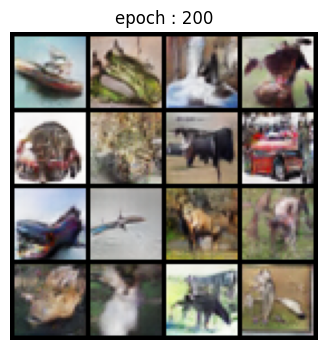

epoch: 201/300 	 D Loss: 0.550 G Loss: 1.259 	 9s
epoch: 202/300 	 D Loss: 0.554 G Loss: 1.267 	 9s
epoch: 203/300 	 D Loss: 0.554 G Loss: 1.263 	 9s
epoch: 204/300 	 D Loss: 0.554 G Loss: 1.268 	 9s
epoch: 205/300 	 D Loss: 0.553 G Loss: 1.263 	 9s
epoch: 206/300 	 D Loss: 0.554 G Loss: 1.263 	 9s
epoch: 207/300 	 D Loss: 0.550 G Loss: 1.262 	 9s
epoch: 208/300 	 D Loss: 0.554 G Loss: 1.271 	 9s
epoch: 209/300 	 D Loss: 0.554 G Loss: 1.270 	 9s
epoch: 210/300 	 D Loss: 0.550 G Loss: 1.267 	 9s


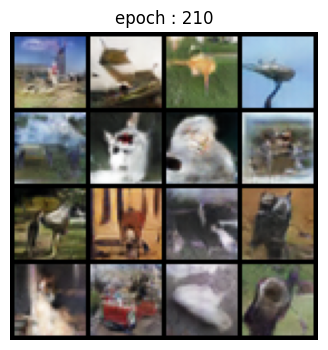

epoch: 211/300 	 D Loss: 0.556 G Loss: 1.274 	 9s
epoch: 212/300 	 D Loss: 0.549 G Loss: 1.259 	 9s
epoch: 213/300 	 D Loss: 0.553 G Loss: 1.268 	 9s
epoch: 214/300 	 D Loss: 0.552 G Loss: 1.270 	 9s
epoch: 215/300 	 D Loss: 0.548 G Loss: 1.266 	 9s
epoch: 216/300 	 D Loss: 0.553 G Loss: 1.273 	 9s
epoch: 217/300 	 D Loss: 0.557 G Loss: 1.264 	 9s
epoch: 218/300 	 D Loss: 0.547 G Loss: 1.275 	 9s
epoch: 219/300 	 D Loss: 0.552 G Loss: 1.276 	 9s
epoch: 220/300 	 D Loss: 0.552 G Loss: 1.266 	 9s


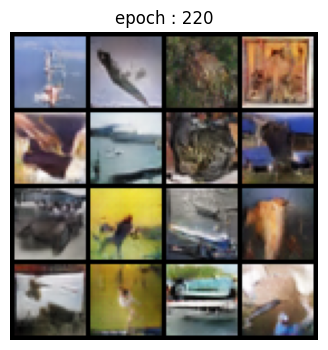

epoch: 221/300 	 D Loss: 0.549 G Loss: 1.274 	 9s
epoch: 222/300 	 D Loss: 0.548 G Loss: 1.279 	 9s
epoch: 223/300 	 D Loss: 0.552 G Loss: 1.273 	 9s
epoch: 224/300 	 D Loss: 0.550 G Loss: 1.278 	 9s
epoch: 225/300 	 D Loss: 0.552 G Loss: 1.277 	 9s
epoch: 226/300 	 D Loss: 0.548 G Loss: 1.278 	 9s
epoch: 227/300 	 D Loss: 0.548 G Loss: 1.274 	 9s
epoch: 228/300 	 D Loss: 0.549 G Loss: 1.284 	 9s
epoch: 229/300 	 D Loss: 0.549 G Loss: 1.282 	 9s
epoch: 230/300 	 D Loss: 0.550 G Loss: 1.287 	 9s


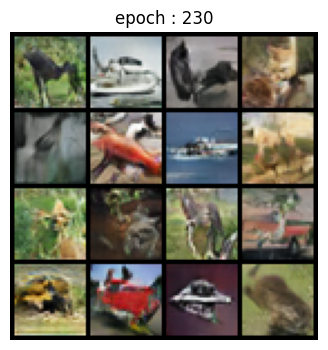

epoch: 231/300 	 D Loss: 0.550 G Loss: 1.287 	 9s
epoch: 232/300 	 D Loss: 0.550 G Loss: 1.282 	 9s
epoch: 233/300 	 D Loss: 0.558 G Loss: 1.298 	 9s
epoch: 234/300 	 D Loss: 0.544 G Loss: 1.262 	 9s
epoch: 235/300 	 D Loss: 0.545 G Loss: 1.275 	 9s
epoch: 236/300 	 D Loss: 0.549 G Loss: 1.291 	 9s
epoch: 237/300 	 D Loss: 0.549 G Loss: 1.289 	 9s
epoch: 238/300 	 D Loss: 0.550 G Loss: 1.278 	 9s
epoch: 239/300 	 D Loss: 0.547 G Loss: 1.288 	 9s
epoch: 240/300 	 D Loss: 0.546 G Loss: 1.289 	 9s


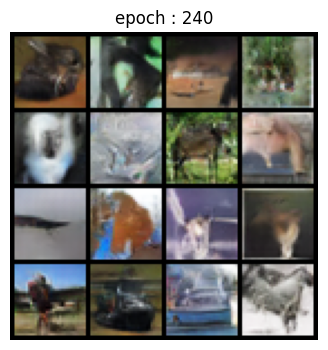

epoch: 241/300 	 D Loss: 0.549 G Loss: 1.282 	 9s
epoch: 242/300 	 D Loss: 0.551 G Loss: 1.289 	 9s
epoch: 243/300 	 D Loss: 0.543 G Loss: 1.290 	 9s
epoch: 244/300 	 D Loss: 0.549 G Loss: 1.290 	 9s
epoch: 245/300 	 D Loss: 0.551 G Loss: 1.295 	 9s
epoch: 246/300 	 D Loss: 0.546 G Loss: 1.281 	 9s
epoch: 247/300 	 D Loss: 0.546 G Loss: 1.290 	 9s
epoch: 248/300 	 D Loss: 0.548 G Loss: 1.292 	 9s
epoch: 249/300 	 D Loss: 0.548 G Loss: 1.299 	 9s
epoch: 250/300 	 D Loss: 0.544 G Loss: 1.299 	 9s


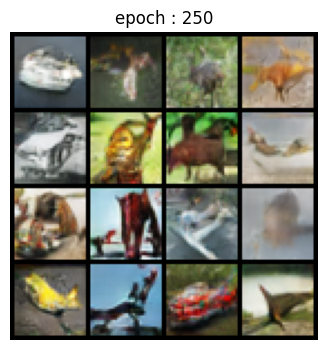

epoch: 251/300 	 D Loss: 0.545 G Loss: 1.302 	 9s
epoch: 252/300 	 D Loss: 0.547 G Loss: 1.304 	 9s
epoch: 253/300 	 D Loss: 0.547 G Loss: 1.301 	 9s
epoch: 254/300 	 D Loss: 0.544 G Loss: 1.290 	 9s
epoch: 255/300 	 D Loss: 0.552 G Loss: 1.303 	 9s
epoch: 256/300 	 D Loss: 0.543 G Loss: 1.293 	 9s
epoch: 257/300 	 D Loss: 0.545 G Loss: 1.303 	 9s
epoch: 258/300 	 D Loss: 0.545 G Loss: 1.306 	 9s
epoch: 259/300 	 D Loss: 0.551 G Loss: 1.301 	 9s
epoch: 260/300 	 D Loss: 0.544 G Loss: 1.292 	 9s


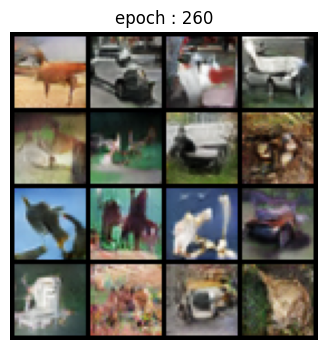

epoch: 261/300 	 D Loss: 0.543 G Loss: 1.302 	 9s
epoch: 262/300 	 D Loss: 0.543 G Loss: 1.305 	 9s
epoch: 263/300 	 D Loss: 0.547 G Loss: 1.309 	 9s
epoch: 264/300 	 D Loss: 0.544 G Loss: 1.307 	 9s
epoch: 265/300 	 D Loss: 0.542 G Loss: 1.299 	 9s
epoch: 266/300 	 D Loss: 0.544 G Loss: 1.307 	 9s
epoch: 267/300 	 D Loss: 0.545 G Loss: 1.296 	 9s
epoch: 268/300 	 D Loss: 0.544 G Loss: 1.292 	 9s
epoch: 269/300 	 D Loss: 0.543 G Loss: 1.310 	 9s
epoch: 270/300 	 D Loss: 0.541 G Loss: 1.308 	 9s


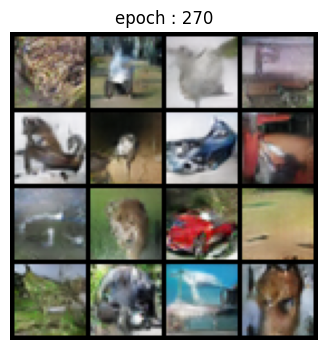

epoch: 271/300 	 D Loss: 0.543 G Loss: 1.313 	 9s
epoch: 272/300 	 D Loss: 0.545 G Loss: 1.309 	 9s
epoch: 273/300 	 D Loss: 0.544 G Loss: 1.305 	 9s
epoch: 274/300 	 D Loss: 0.544 G Loss: 1.306 	 9s
epoch: 275/300 	 D Loss: 0.544 G Loss: 1.309 	 9s
epoch: 276/300 	 D Loss: 0.542 G Loss: 1.305 	 9s
epoch: 277/300 	 D Loss: 0.546 G Loss: 1.317 	 9s
epoch: 278/300 	 D Loss: 0.542 G Loss: 1.313 	 9s
epoch: 279/300 	 D Loss: 0.542 G Loss: 1.319 	 9s
epoch: 280/300 	 D Loss: 0.545 G Loss: 1.318 	 9s


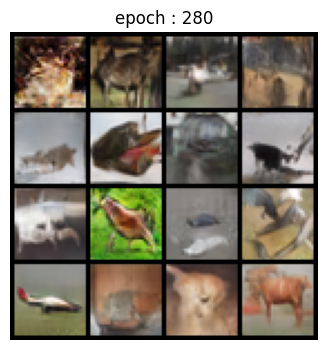

epoch: 281/300 	 D Loss: 0.544 G Loss: 1.317 	 9s
epoch: 282/300 	 D Loss: 0.542 G Loss: 1.310 	 9s
epoch: 283/300 	 D Loss: 0.543 G Loss: 1.316 	 9s
epoch: 284/300 	 D Loss: 0.541 G Loss: 1.316 	 9s
epoch: 285/300 	 D Loss: 0.541 G Loss: 1.327 	 9s
epoch: 286/300 	 D Loss: 0.545 G Loss: 1.318 	 9s
epoch: 287/300 	 D Loss: 0.559 G Loss: 1.342 	 9s
epoch: 288/300 	 D Loss: 0.539 G Loss: 1.279 	 9s
epoch: 289/300 	 D Loss: 0.539 G Loss: 1.309 	 9s
epoch: 290/300 	 D Loss: 0.539 G Loss: 1.316 	 9s


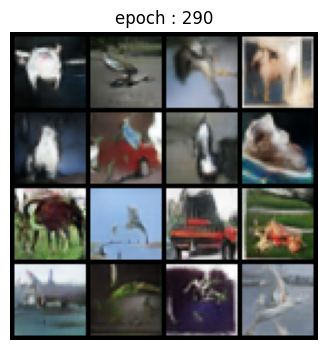

epoch: 291/300 	 D Loss: 0.545 G Loss: 1.324 	 9s
epoch: 292/300 	 D Loss: 0.545 G Loss: 1.320 	 9s
epoch: 293/300 	 D Loss: 0.536 G Loss: 1.325 	 9s
epoch: 294/300 	 D Loss: 0.545 G Loss: 1.328 	 9s
epoch: 295/300 	 D Loss: 0.542 G Loss: 1.324 	 9s
epoch: 296/300 	 D Loss: 0.543 G Loss: 1.324 	 9s
epoch: 297/300 	 D Loss: 0.537 G Loss: 1.325 	 9s
epoch: 298/300 	 D Loss: 0.543 G Loss: 1.324 	 9s
epoch: 299/300 	 D Loss: 0.540 G Loss: 1.324 	 9s
epoch: 300/300 	 D Loss: 0.539 G Loss: 1.328 	 9s


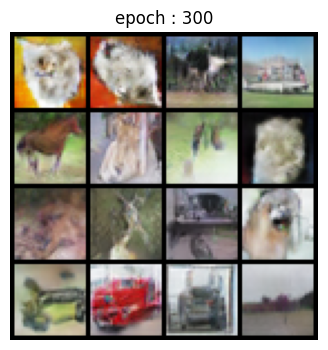

learning time (300 epoch) : 45m 24


In [ ]:
epochs = 300

total_time = list()

d_loss_list = list()
g_loss_list = list()

for epoch in range(1, epochs+1):
    now = time()
    d_avg_loss = 0.0
    g_avg_loss = 0.0

    for i, data in enumerate(trainset):
        x, _ = data
        x = x.to(device)

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        batch_size = x.size(0)
        real_labels = torch.ones(batch_size, 1, device=device) * 0.8 + 0.05 * torch.rand(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device) + 0.2 * torch.rand(batch_size, 1, device=device)

        # D training
        for _ in range(2):
            z = torch.randn(batch_size, latent_size, device=device)
            fake_imgs = G(z)

            real_loss = loss_function(D(x), real_labels)
            fake_loss = loss_function(D(fake_imgs.detach()), fake_labels)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            d_optimizer.step()

        # G training
        z = torch.randn(batch_size, latent_size, device=device)
        fake_imgs = G(z)    

        g_loss = loss_function(D(fake_imgs), real_labels)
        g_loss.backward()
        g_optimizer.step()
            
        d_avg_loss += d_loss.item()
        g_avg_loss += g_loss.item()

        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())

    learning_time = int(time() - now)
    total_time.append(learning_time)

    print(f"epoch: {epoch:3d}/{epochs} \t D Loss: {d_avg_loss/len(trainset):.3f} G Loss: {g_avg_loss/len(trainset):.3f} \t {learning_time}s")

    if epoch % 10 == 0:
        fake_images = fake_imgs.detach().view(-1, 3, 32, 32)
        plt.figure(figsize=(4, 4))
        plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"epoch : {epoch}")
        plt.show()
    

print(f"learning time ({epochs} epoch) : {floor(sum(total_time) / 60)}m {sum(total_time) % 60}")

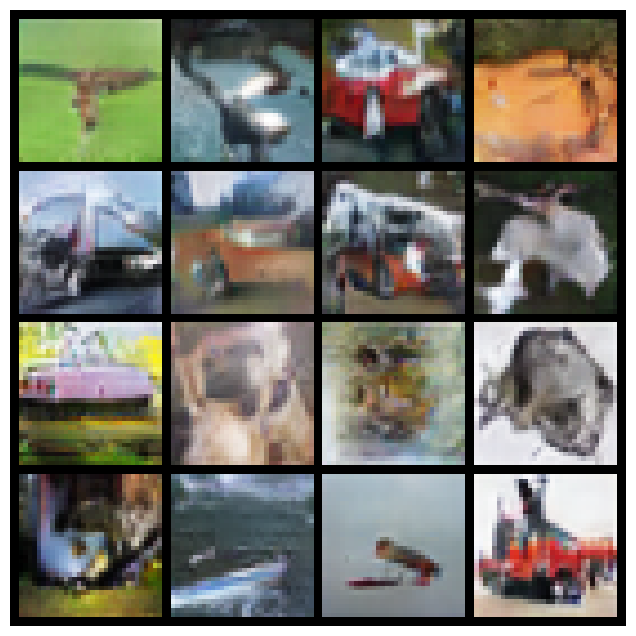

In [10]:
z = torch.randn(batch_size, latent_size, device=device)
fake_images = G(z)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1,2,0))
plt.axis("off")
plt.show()

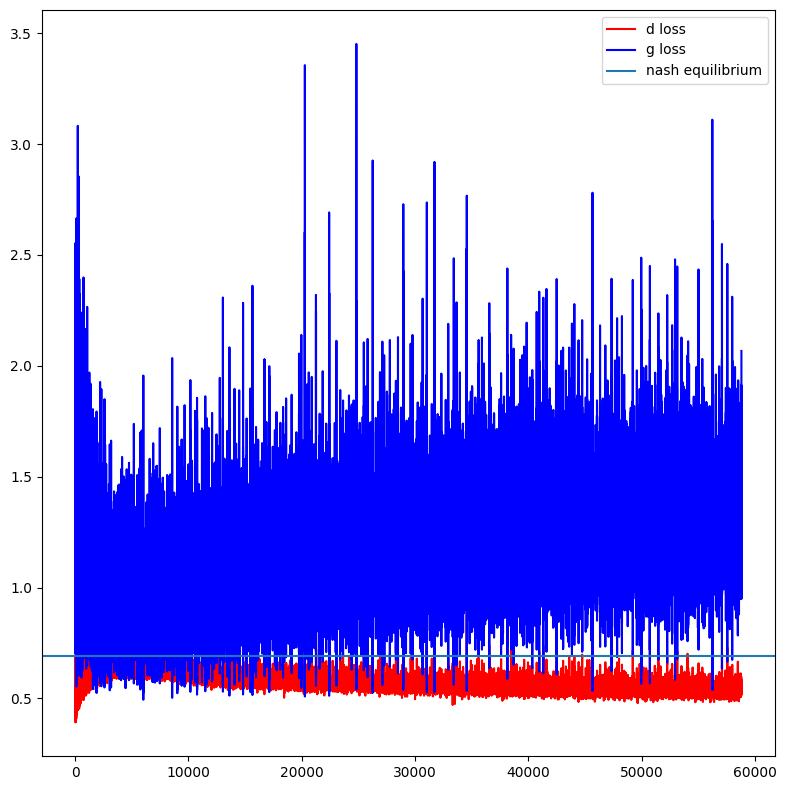

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(d_loss_list) + 1), d_loss_list, label='d loss', color='red')
plt.plot(range(1, len(d_loss_list) + 1), g_loss_list, label='g loss', color='blue')
plt.axhline(y=np.log(2), label='nash equilibrium')
plt.tight_layout()
plt.legend()
plt.show()

그래프 해석 : g loss 와 d loss는 각각 0.5 / 1.3 정도에 수렴하는 상태 (진동은 있으나 크게 차이가 없음) = 에폭을 늘려도 더 이상의 학습효과 없음